# Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

In [2]:
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]

# Load data & Create New Dataframe

## Load Data

In [3]:
df_ = pd.read_csv("../data/tidy-scooters.csv", index_col= 'Start', parse_dates= ['Start', 'End'])

In [4]:
df_.head()

,TripID,End,Duration,Distance,StartLatitude,StartLongitude,EndLatitude,EndLongitude,DayOfWeek,HourNum,WeekOfYear,Covid
Start,,,,,,,,,,,,
2019-06-26 19:30:00,0000045c-2677-3a7d-4b73-cad99a57,2019-06-26 19:30:00,3,0,38.253,-85.756,38.253,-85.755,4,19,26,0
2019-09-22 14:30:00,0000487b-92e6-50d6-7569-42ed3818,2019-09-22 14:30:00,5,0,38.203,-85.752,38.204,-85.751,1,14,38,0
2019-08-21 17:30:00,00006088-2579-e0d0-6a30-a15bb878,2019-08-21 17:30:00,6,531,38.259,-85.733,38.265,-85.739,4,17,34,0
2019-07-03 11:00:00,00008c1a-899b-8596-970f-9f6bf495,2019-07-03 11:15:00,6,1030,38.217,-85.757,38.221,-85.763,4,11,27,0
2019-11-22 10:45:00,00009301-3225-2aea-a84a-165a480a,2019-11-22 11:00:00,7,964,38.215,-85.759,38.222,-85.764,6,10,47,0


In [5]:
df_.dtypes

TripID                    object
End               datetime64[ns]
Duration                   int64
Distance                   int64
StartLatitude            float64
StartLongitude           float64
EndLatitude              float64
EndLongitude             float64
DayOfWeek                  int64
HourNum                    int64
WeekOfYear                 int64
Covid                      int64
dtype: object

## Resample Features

In [6]:
df = df_.resample('1H').agg({'TripID': 'nunique',
                                 'Duration': 'mean',
                                 'Distance': 'mean'
}).reset_index()

In [7]:
df.isnull().sum()

Start          0
TripID         0
Duration    4228
Distance    4228
dtype: int64

In [8]:
df.rename(columns = {'TripID': 'Count', 'Start': 'Date'}, inplace = True)
df.set_index('Date', inplace= True)
df.head()

,Count,Duration,Distance
Date,,,
2018-08-09 10:00:00,12,25.750000,2571.750000
2018-08-09 11:00:00,29,11.068966,1776.620690
2018-08-09 12:00:00,34,16.235294,2767.882353
2018-08-09 13:00:00,38,19.763158,3450.026316
2018-08-09 14:00:00,12,12.666667,2001.833333


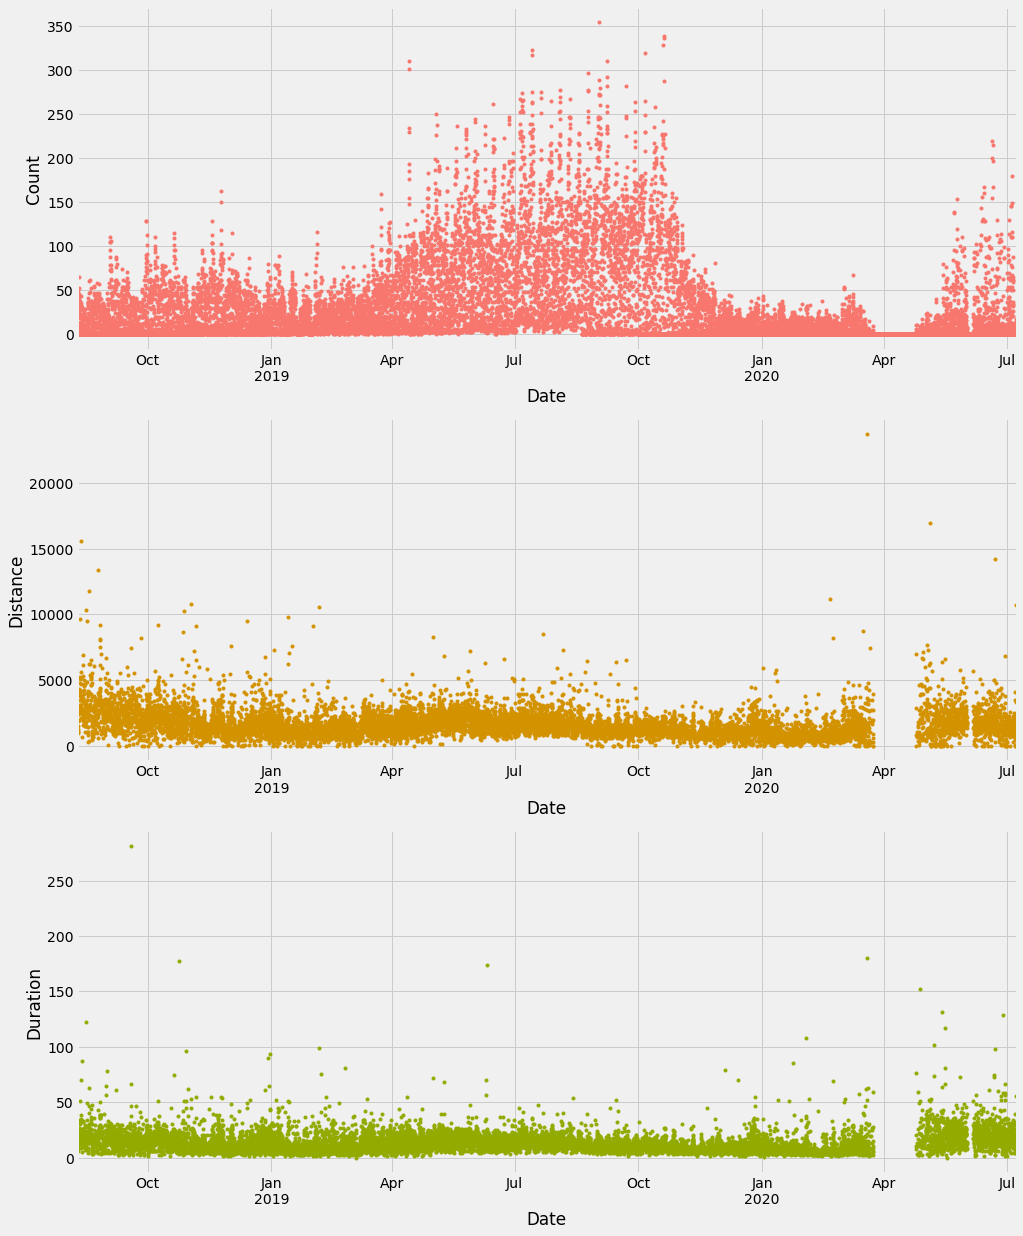

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(15,20))

df.Count.plot(style='.', ax = ax[0], color=color_pal[0], ylabel = 'Count')
df.Distance.plot(style='.', ax = ax[1], color=color_pal[1], ylabel = 'Distance')
df.Duration.plot(style='.', ax = ax[2], color=color_pal[2], ylabel = 'Duration')

plt.show()

## Time Features

In [221]:
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day # day of month
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if target:
        y = df[label]
        return X, y
    return X

In [222]:
X = create_time_features(df)

In [223]:
df = pd.concat([df, X], axis=1)

In [ ]:
df.head()

,Count,Duration,Distance,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,
2018-08-09 10:00:00,12,25.750000,2571.750000,10,3,3,8,2018,221,9,32
2018-08-09 11:00:00,29,11.068966,1776.620690,11,3,3,8,2018,221,9,32
2018-08-09 12:00:00,34,16.235294,2767.882353,12,3,3,8,2018,221,9,32
2018-08-09 13:00:00,38,19.763158,3450.026316,13,3,3,8,2018,221,9,32
2018-08-09 14:00:00,12,12.666667,2001.833333,14,3,3,8,2018,221,9,32


## Exclude Covid-19 trips

In [225]:
precovid = df.loc[df.index < '2020-03-21 00:00:00']

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15,20))

precovid.Count.plot(style='.', ax = ax[0], color=color_pal[0], ylabel = 'Count')
precovid.Distance.plot(style='.', ax = ax[1], color=color_pal[1], ylabel = 'Distance')
precovid.Duration.plot(style='.', ax = ax[2], color=color_pal[2], ylabel = 'Duration')

plt.show()

## Pairplot

In [ ]:
sns.pairplot(precovid.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars=['Count', 'Distance', 'Duration'],
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0},
             # diag_kind= 'hist'
            )
plt.suptitle('Escooters Usage by hour, day of the week, week of the year and year')
plt.show()

# First Split

In [228]:
split_date = '2020-01-01 00:00:00'

df_train = df.loc[df.index < split_date]
df_test = df.loc[df.index >= split_date]

In [229]:
df_train.head()

,Count,Duration,Distance,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,
2018-08-09 10:00:00,12,25.750000,2571.750000,10,3,3,8,2018,221,9,32
2018-08-09 11:00:00,29,11.068966,1776.620690,11,3,3,8,2018,221,9,32
2018-08-09 12:00:00,34,16.235294,2767.882353,12,3,3,8,2018,221,9,32
2018-08-09 13:00:00,38,19.763158,3450.026316,13,3,3,8,2018,221,9,32
2018-08-09 14:00:00,12,12.666667,2001.833333,14,3,3,8,2018,221,9,32


## Define Targets

We have to reset index and rename dates to 'ds' and targets to 'y' because 'fbprophet' can only work with features named this way (...)

In [230]:
count_train = df_train['Count'].reset_index().rename(columns = {'Date': 'ds', 'Count': 'y'})
distance_train = df_train['Distance'].reset_index().rename(columns = {'Date': 'ds', 'Distance': 'y'})
duration_train = df_train['Duration'].reset_index().rename(columns = {'Date': 'ds', 'Duration': 'y'})

count_test = df_test['Count'].reset_index().rename(columns = {'Date': 'ds', 'Count': 'y'})
distance_test = df_test['Distance'].reset_index().rename(columns = {'Date': 'ds', 'Distance': 'y'})
duration_test = df_test['Duration'].reset_index().rename(columns = {'Date': 'ds', 'Duration': 'y'})

In [231]:
count_train.head()

,ds,y
0,2018-08-09 10:00:00,12
1,2018-08-09 11:00:00,29
2,2018-08-09 12:00:00,34
3,2018-08-09 13:00:00,38
4,2018-08-09 14:00:00,12


In [232]:
train = [count_train, distance_train, duration_train]
test = [count_test, distance_test, duration_test]

## Create Model

In [233]:
models = []
for col in train:
    model = Prophet()
    model.fit(col)
    models.append(model)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
models

In [234]:
forecasts = []
for i, col in enumerate(test):
    forecast = models[i].predict(col)
    forecasts.append(forecast)

In [ ]:
forecasts[0][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-01 00:00:00,-51.201286,-91.613030,-10.745462
1,2020-01-01 01:00:00,-54.152407,-95.990346,-18.401696
2,2020-01-01 02:00:00,-53.708210,-92.594093,-14.367794
3,2020-01-01 03:00:00,-51.468891,-90.711314,-11.806250
4,2020-01-01 04:00:00,-48.255242,-86.192968,-8.919867


## Predictions & Plots

In [ ]:
f, ax = plt.subplots(3,1, figsize = (15, 20))

for i in range(0,3):
    fig = models[i].plot(forecasts[i], ax = ax[i])

plt.show()

## Display Trends

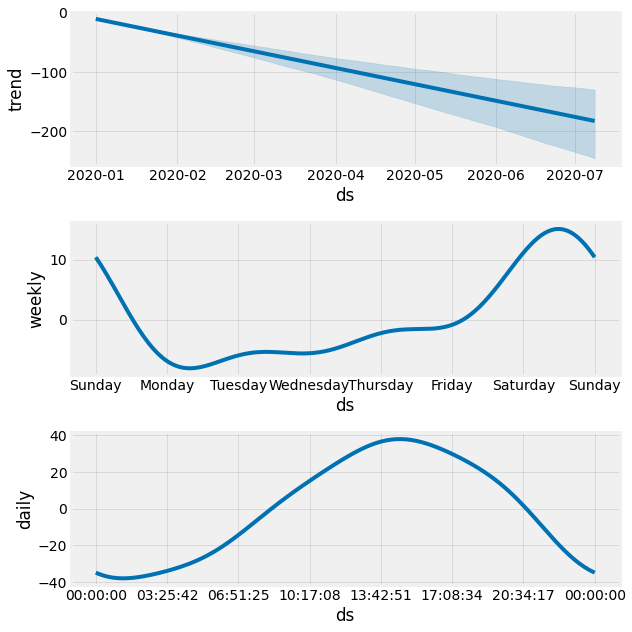

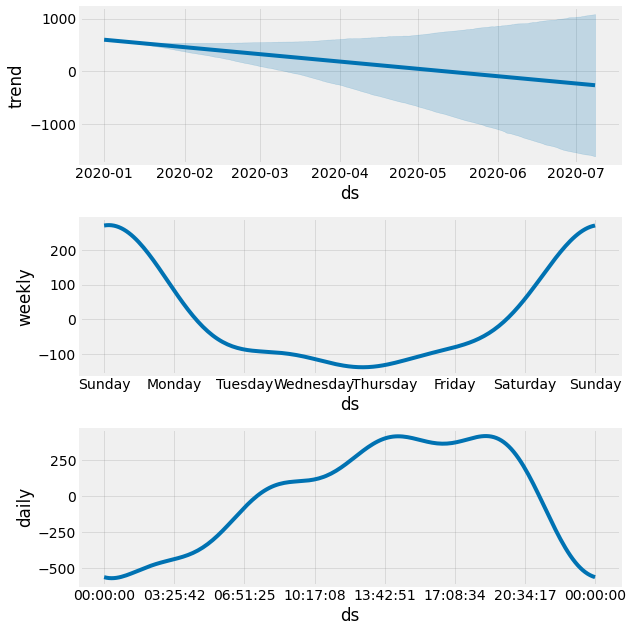

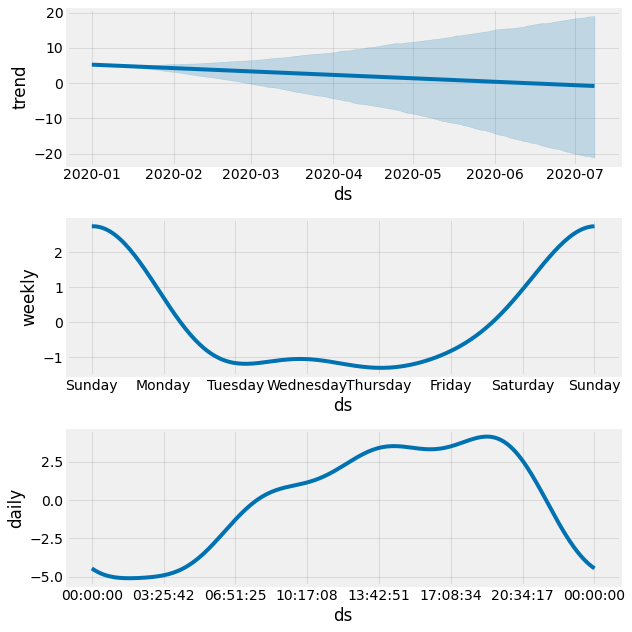

In [236]:
for i in range(0,3):
    fig = models[i].plot_components(forecasts[i])

## Compare Forecast to Actual

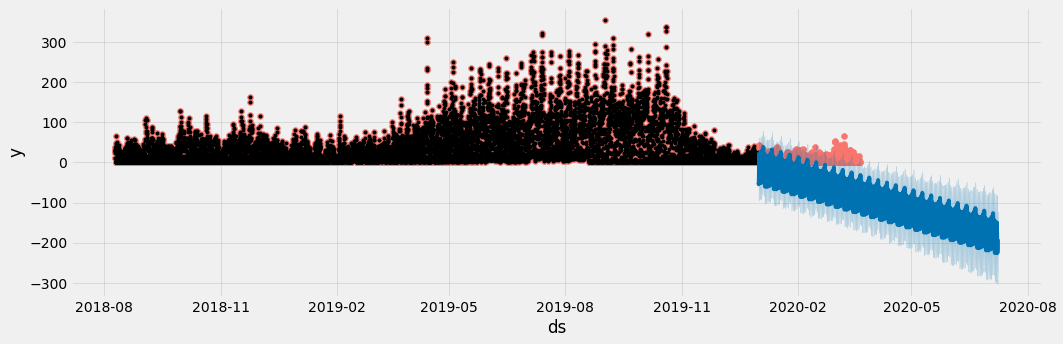

In [240]:
f, ax = plt.subplots(1, figsize = (15, 5))
ax.scatter(precovid.Count.index, precovid.Count, color=color_pal[0])
fig = models[0].plot(forecasts[0], ax=ax)

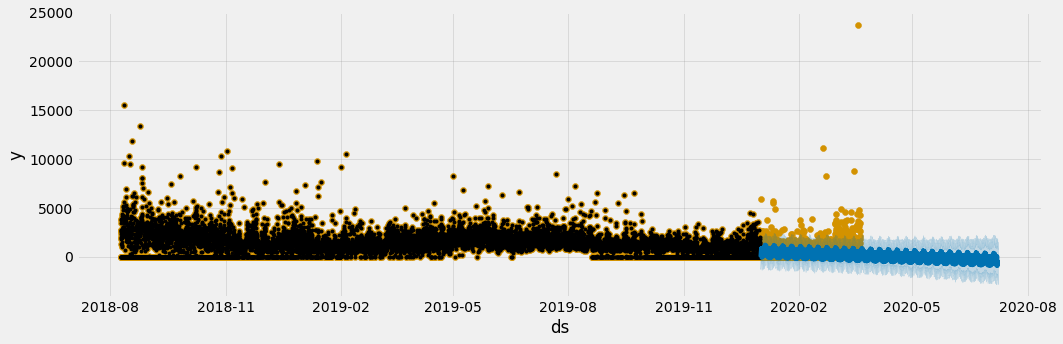

In [244]:
f, ax = plt.subplots(1, figsize = (15, 5))
ax.scatter(precovid.Distance.index, precovid.Distance, color=color_pal[1])
fig = models[1].plot(forecasts[1], ax=ax)

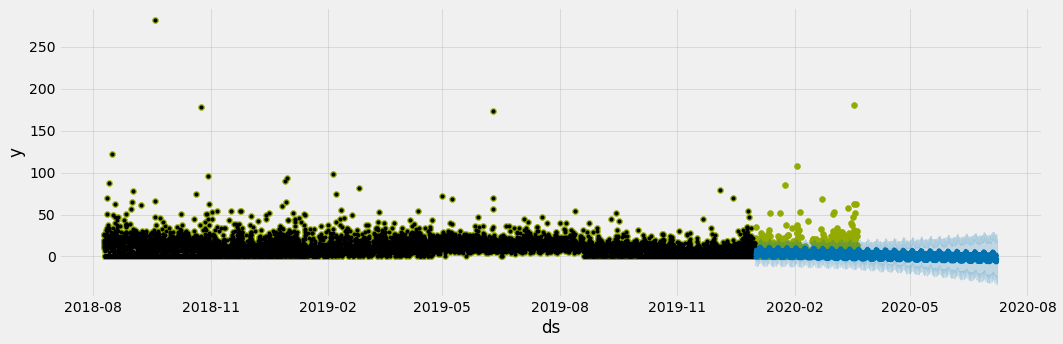

In [ ]:
f, ax = plt.subplots(1, figsize = (15, 5))
ax.scatter(precovid.Duration.index, precovid.Duration, color=color_pal[2])
fig = models[2].plot(forecasts[2], ax=ax)

# Change Split!

In [245]:
split_date = '2019-08-01 00:00:00'

df_train = df.loc[df.index < split_date]
df_test = df.loc[df.index >= split_date]

## Define Targets

We have to reset index and rename dates to 'ds' and targets to 'y' because 'fbprophet' can only work with features named this way (...)

In [246]:
count_train = df_train['Count'].reset_index().rename(columns = {'Date': 'ds', 'Count': 'y'})
distance_train = df_train['Distance'].reset_index().rename(columns = {'Date': 'ds', 'Distance': 'y'})
duration_train = df_train['Duration'].reset_index().rename(columns = {'Date': 'ds', 'Duration': 'y'})

count_test = df_test['Count'].reset_index().rename(columns = {'Date': 'ds', 'Count': 'y'})
distance_test = df_test['Distance'].reset_index().rename(columns = {'Date': 'ds', 'Distance': 'y'})
duration_test = df_test['Duration'].reset_index().rename(columns = {'Date': 'ds', 'Duration': 'y'})

In [247]:
count_train.head()

,ds,y
0,2018-08-09 10:00:00,12
1,2018-08-09 11:00:00,29
2,2018-08-09 12:00:00,34
3,2018-08-09 13:00:00,38
4,2018-08-09 14:00:00,12


In [248]:
train = [count_train, distance_train, duration_train]
test = [count_test, distance_test, duration_test]

## Create Model

In [249]:
models = []
for col in train:
    model = Prophet()
    model.fit(col)
    models.append(model)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
models

In [250]:
forecasts = []
for i, col in enumerate(test):
    forecast = models[i].predict(col)
    forecasts.append(forecast)

In [ ]:
forecasts[0][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-08-01 00:00:00,55.600590,19.915240,88.941385
1,2019-08-01 01:00:00,52.257544,16.657923,87.801663
2,2019-08-01 02:00:00,52.196315,19.163934,86.403447
3,2019-08-01 03:00:00,54.559328,21.481278,86.527630
4,2019-08-01 04:00:00,58.295005,25.338123,93.942498


## Predictions & Plots

In [ ]:
f, ax = plt.subplots(3,1, figsize = (15, 20))

for i in range(0,3):
    fig = models[i].plot(forecasts[i], ax = ax[i])

plt.show()

## Display Trends

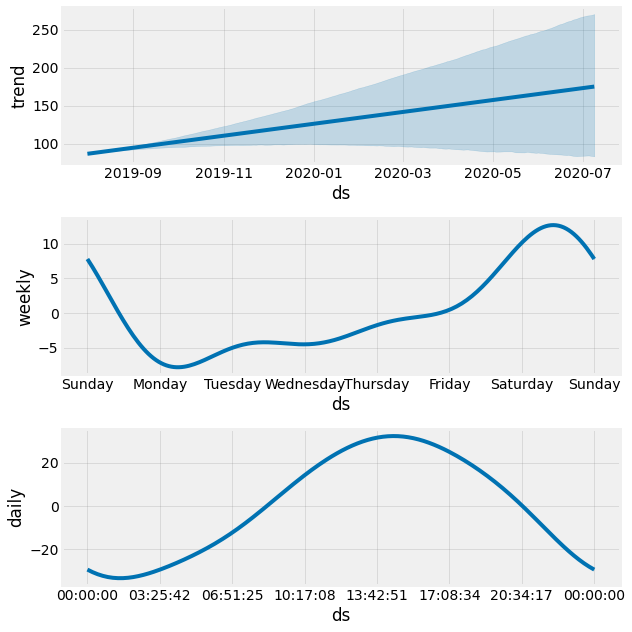

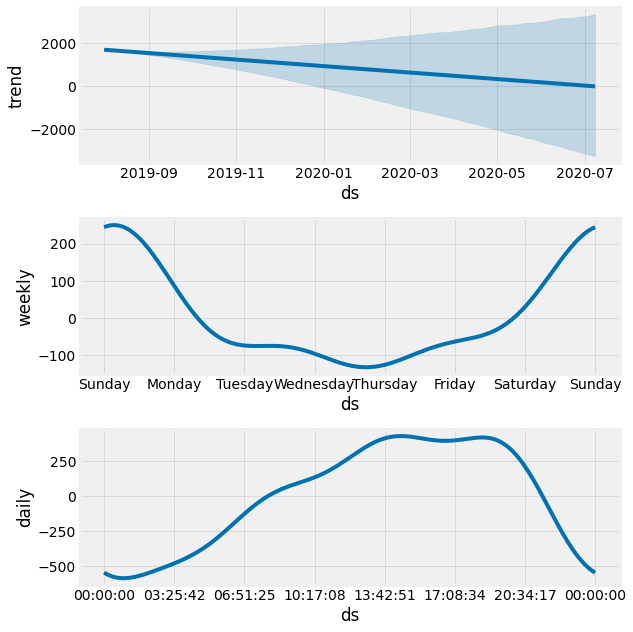

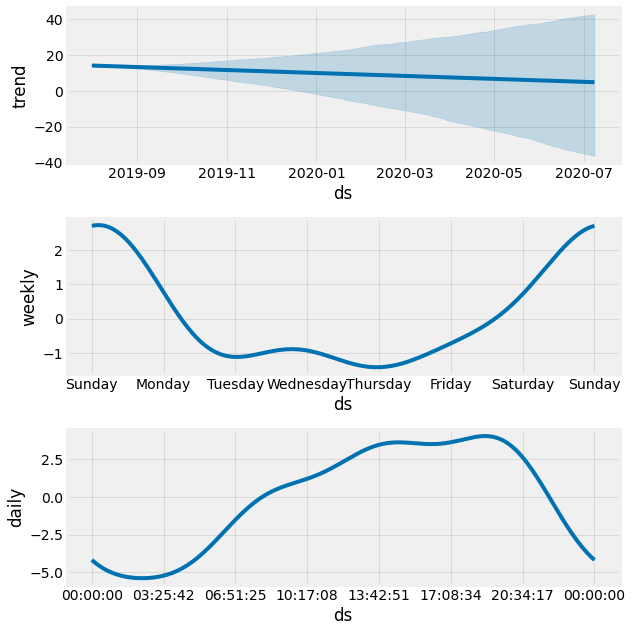

In [252]:
for i in range(0,3):
    fig = models[i].plot_components(forecasts[i])
    

## Compare Forecast to Actual

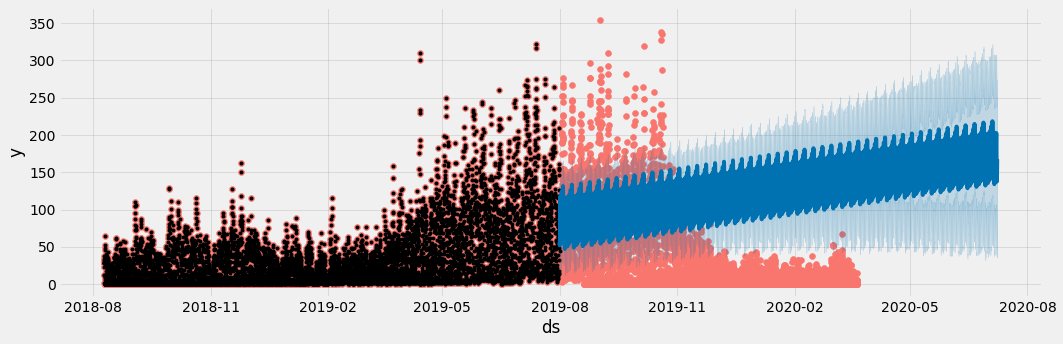

In [253]:
f, ax = plt.subplots(1, figsize = (15, 5))
ax.scatter(precovid.Count.index, precovid.Count, color=color_pal[0])
fig = models[0].plot(forecasts[0], ax=ax)

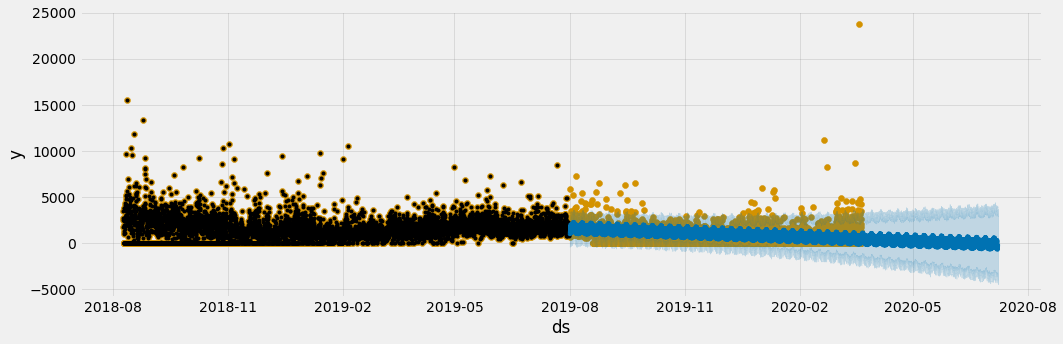

In [254]:
f, ax = plt.subplots(1, figsize = (15, 5))
ax.scatter(precovid.Distance.index, precovid.Distance, color=color_pal[1])
fig = models[1].plot(forecasts[1], ax=ax)

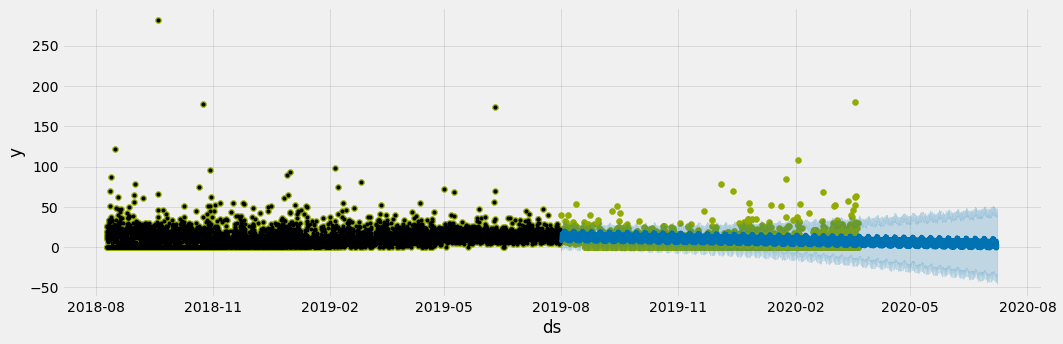

In [255]:
f, ax = plt.subplots(1, figsize = (15, 5))
ax.scatter(precovid.Duration.index, precovid.Duration, color=color_pal[2])
fig = models[2].plot(forecasts[2], ax=ax)

# Use Logged Data

In [256]:
df = df_.resample('1H').agg({'TripID': 'nunique',
                                 'Duration': 'mean',
                                 'Distance': 'mean'}).reset_index()

In [257]:
df.rename(columns = {'TripID': 'Count', 'Start': 'Date'}, inplace = True)
df.set_index('Date', inplace= True)

In [258]:
df = df[['Count', 'Duration', 'Distance']]
df.head()

,Count,Duration,Distance
Date,,,
2018-08-09 10:00:00,12,25.750000,2571.750000
2018-08-09 11:00:00,29,11.068966,1776.620690
2018-08-09 12:00:00,34,16.235294,2767.882353
2018-08-09 13:00:00,38,19.763158,3450.026316
2018-08-09 14:00:00,12,12.666667,2001.833333


In [259]:
for col in df.columns:
  df[col] = df[col].fillna(0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16775 entries, 2018-08-09 10:00:00 to 2020-07-08 08:00:00
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Count     16775 non-null  int64  
 1   Duration  16775 non-null  float64
 2   Distance  16775 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 524.2 KB


In [260]:
log_df = df.copy()
log_df = log_df.between_time('07:00:00','21:00:00')

In [261]:
for col in df.columns:
    log_df[col] = np.log(df[col])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log



In [262]:
log_df.replace(-np.inf, 0, inplace = True)

In [ ]:
log_df.value_counts()

Count     Duration  Distance
0.000000  0.000000  0.000000    836
0.693147  1.704748  7.075386      2
1.609438  2.001480  7.054968      2
0.693147  1.098612  5.551020      2
0.000000  1.386294  0.000000      2
                               ... 
3.988984  2.681782  7.379494      1
          2.649584  7.506917      1
          2.619017  7.555033      1
          2.616314  7.359008      1
3.465736  2.140066  7.136980      1
Length: 9641, dtype: int64

## Split

In [263]:
split_date = '2019-08-01 00:00:00'

df_train = log_df.loc[log_df.index < split_date]
df_test = log_df.loc[log_df.index >= split_date]

## Define Targets

We have to reset index and rename dates to 'ds' and targets to 'y' because 'fbprophet' can only work with features named this way (...)

In [264]:
count_train = df_train['Count'].reset_index().rename(columns = {'Date': 'ds', 'Count': 'y'})
distance_train = df_train['Distance'].reset_index().rename(columns = {'Date': 'ds', 'Distance': 'y'})
duration_train = df_train['Duration'].reset_index().rename(columns = {'Date': 'ds', 'Duration': 'y'})

count_test = df_test['Count'].reset_index().rename(columns = {'Date': 'ds', 'Count': 'y'})
distance_test = df_test['Distance'].reset_index().rename(columns = {'Date': 'ds', 'Distance': 'y'})
duration_test = df_test['Duration'].reset_index().rename(columns = {'Date': 'ds', 'Duration': 'y'})

In [ ]:
count_train.head()

,ds,y
0,2018-08-09 10:00:00,2.484907
1,2018-08-09 11:00:00,3.367296
2,2018-08-09 12:00:00,3.526361
3,2018-08-09 13:00:00,3.637586
4,2018-08-09 14:00:00,2.484907


In [265]:
train = [count_train, distance_train, duration_train]
test = [count_test, distance_test, duration_test]

## Create Model

In [266]:
models = []
for col in train:
    model = Prophet()
    model.fit(col)
    models.append(model)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
models

In [267]:
forecasts = []
for i, col in enumerate(test):
    forecast = models[i].predict(col)
    forecasts.append(forecast)

In [ ]:
forecasts[0][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-08-01 07:00:00,3.799825,2.873039,4.756032
1,2019-08-01 08:00:00,4.269163,3.382213,5.164009
2,2019-08-01 09:00:00,4.427404,3.462632,5.325571
3,2019-08-01 10:00:00,4.652068,3.750020,5.579613
4,2019-08-01 11:00:00,4.919446,4.013961,5.799640


## Predictions & Plots

In [ ]:
f, ax = plt.subplots(3,1, figsize = (15, 20))

for i in range(0,3):
    fig = models[i].plot(forecasts[i], ax = ax[i])

plt.show()

## Display Trends

In [ ]:
for i in range(0,3):
    fig = models[i].plot_components(forecasts[i])
    

## Compare Forecast to Actual

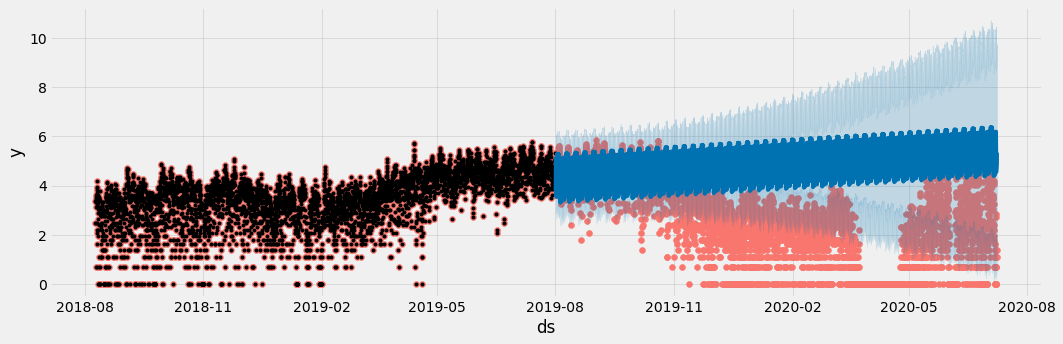

In [270]:
f, ax = plt.subplots(1, figsize = (15, 5))
ax.scatter(log_df.Count.index, log_df.Count, color=color_pal[0])
fig = models[0].plot(forecasts[0], ax=ax)

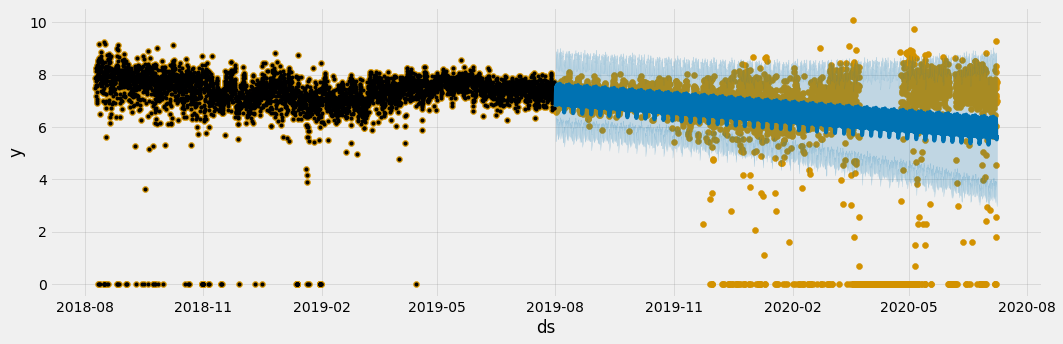

In [271]:
f, ax = plt.subplots(1, figsize = (15, 5))
ax.scatter(log_df.Distance.index, log_df.Distance, color=color_pal[1])
fig = models[1].plot(forecasts[1], ax=ax)

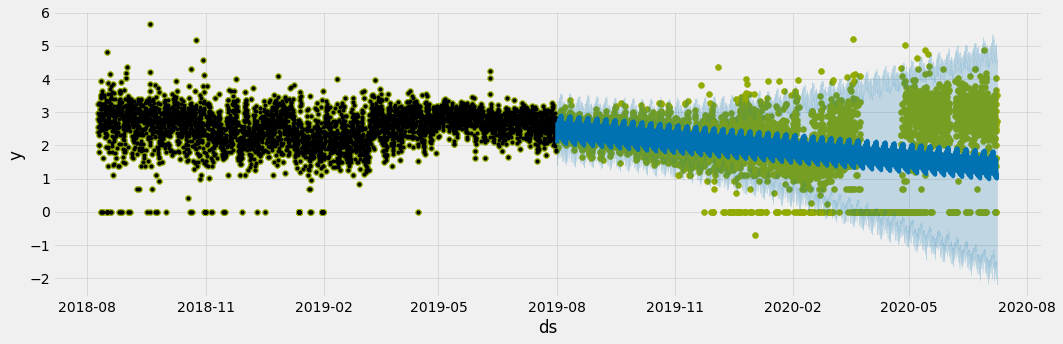

In [272]:
f, ax = plt.subplots(1, figsize = (15, 5))
ax.scatter(log_df.Duration.index, log_df.Duration, color=color_pal[2])
fig = models[2].plot(forecasts[2], ax=ax)